In [18]:
%time
# import module
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
def expand2square(img, background_color):
    '''
    padding

    -----------
    img: a image file
    background_color: RGB 3-dimensional
    '''
    width, height = img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(img.mode, (width, width), background_color)
        result.paste(img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(img.mode, (height, height), background_color)
        result.paste(img, ((height - width) // 2, 0))
        return result

Wall time: 0 ns


In [3]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [7]:
class Arcfacelayer(Layer):
    def __init__(self, output_dim, s=30,m=0.50, easy_magin=False):
        self.output_dim = output_dim
        self.s = s
        self.m = m
        self.easy_magin = easy_magin
        super(Arcfacelayer, self).__init__()
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Arcfacelayer, self).build(input_shape)
        
    def call(self, x):
        y = x[1]
        x_normalize = tf.math.l2_normalize(x[0]) #|x = x'/ ||x'||2
        k_normalize = tf.math.l2_normalize(self.kernel) # Wj = Wj' / ||Wj'||2
        
        cos_m = K.cos(self.m)
        sin_m = K.sin(self.m)
        th = K.cos(np.pi - self.m)
        mm = K.sin(np.pi - self.m) * self.m
        
        cosine = K.dot(x_normalize, k_normalize) # W.Txの内積
        print('cosine{}'.format(cosine.shape))
        sine = K.sqrt(1.0 - K.square(cosine))
        print('sine{}'.format(sine.shape))
        phi = cosine * cos_m - sine * sin_m
        
        if self.easy_magin:
            phi = tf.where(cosine > 0, phi, cosine) 
            
        else:
            phi = tf.where(cosine > th, phi, cosine - mm) 
        
        print('phi{}'.format(phi.shape))
        
        
        output = (y * phi) + ((1.0 - y) * cosine) # true cos(θ+m), False cos(θ)
        output *= self.s
        
        return output
    
    def compute_output_shape(self, input_shape):
        
        return (input_shape[0][0], self.output_dim)
        #return self.output_dim

In [8]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input,Dropout,Activation
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import CSVLogger,EarlyStopping
from livelossplot.keras import PlotLossesCallback
%matplotlib inline

n_categories=5
batch_size=32
train_dir = './images/train'
validation_dir = './images/val'
file_name='MobileNetV2_shape224'

base_model=MobileNetV2(input_shape=(224,224,3),
                       weights='imagenet',
                       include_top=False)

#add new layers instead of FC networks
x = base_model.output
yinput = Input(shape=(n_categories,))
# stock hidden model
hidden = GlobalAveragePooling2D()(x)
# stock Feature extraction
x = Dropout(0.5)(hidden)
x = Arcfacelayer(5, 30, 0.5)([x,yinput])
#x = Dense(1024,activation='relu')(x)
prediction = Activation('softmax')(x)
model = Model(inputs=[base_model.input,yinput],outputs=prediction)

model.summary()
#fix weights before MobileNet
for layer in base_model.layers[:85]:
    layer.trainable=True

model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#save model
#train_datagen=ImageDataGenerator(
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #rescale=1.0/255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #vertical_flip=True,
    #horizontal_flip=True)

#validation_datagen=ImageDataGenerator(rescale=1.0/255)

#train_generator=train_datagen.flow_from_directory(
    #train_dir,
    ##target_size=(224,224),
    #batch_size=batch_size,
    #class_mode='categorical',
    #shuffle=True
#)

#validation_generator=validation_datagen.flow_from_directory(
    #validation_dir,
    #target_size=(224,224),
    #batch_size=batch_size,
    #class_mode='categorical',
    #shuffle=True
#)


cosine(?, 5)
sine(?, 5)
phi(?, 5)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________

In [6]:
# generator
zoom_size = 0.2
datagen = ImageDataGenerator(horizontal_flip = True,
                             vertical_flip = False,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             rescale=1.0/255,
                             zoom_range=[zoom_size, zoom_size], 
                             brightness_range=[0.1, 1.3], 
                             fill_mode = "constant", 
                             cval=0)

validation_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 15000 images belonging to 5 classes.
Found 6250 images belonging to 5 classes.


In [9]:
# fit
#epoch = 100
count = 0
for (x, y), (val_x, val_y) in zip(train_generator, validation_generator):
    count += 1
    print('count{}'.format(count))
    model.fit([x,y], y, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=([val_x,val_y],val_y), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
    print('---------')
    if count == 10000:
        break

count1
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 11s 339ms/step - loss: 15.7618 - acc: 0.0000e+00 - val_loss: 15.7648 - val_acc: 0.0000e+00
---------
count2
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 15.7481 - acc: 0.0000e+00 - val_loss: 15.7848 - val_acc: 0.0000e+00
---------
count3
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 15.7845 - acc: 0.0000e+00 - val_loss: 15.7808 - val_acc: 0.0000e+00
---------
count4
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 15.7500 - acc: 0.0000e+00 - val_loss: 15.7853 - val_acc: 0.0000e+00
---------
count5
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 15.7428 - acc: 0.0000e+00 - val_loss: 15.7589 - val_acc: 0.0000e+00
---

---------
count42
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 15.4050 - acc: 0.0000e+00 - val_loss: 15.7275 - val_acc: 0.0000e+00
---------
count43
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 15.4593 - acc: 0.0000e+00 - val_loss: 15.7094 - val_acc: 0.0000e+00
---------
count44
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 15.3999 - acc: 0.0000e+00 - val_loss: 15.7162 - val_acc: 0.0000e+00
---------
count45
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 15.3711 - acc: 0.0000e+00 - val_loss: 15.7080 - val_acc: 0.0000e+00
---------
count46
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 15.3657 - acc: 0.0000e+00 - val_loss: 15.6646 - val_acc: 0

---------
count83
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.9970 - acc: 0.0000e+00 - val_loss: 15.6830 - val_acc: 0.0000e+00
---------
count84
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.9363 - acc: 0.0000e+00 - val_loss: 15.7140 - val_acc: 0.0000e+00
---------
count85
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.9192 - acc: 0.0000e+00 - val_loss: 15.6892 - val_acc: 0.0000e+00
---------
count86
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 15.0334 - acc: 0.0000e+00 - val_loss: 15.5959 - val_acc: 0.0000e+00
---------
count87
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.9817 - acc: 0.0000e+00 - val_loss: 15.7031 - val_acc: 0

---------
count124
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.8090 - acc: 0.0000e+00 - val_loss: 15.4336 - val_acc: 0.0000e+00
---------
count125
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.7794 - acc: 0.0000e+00 - val_loss: 15.6099 - val_acc: 0.0000e+00
---------
count126
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.6419 - acc: 0.0000e+00 - val_loss: 15.6524 - val_acc: 0.0000e+00
---------
count127
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.7660 - acc: 0.0000e+00 - val_loss: 15.3849 - val_acc: 0.0000e+00
---------
count128
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.6919 - acc: 0.0000e+00 - val_loss: 15.3657 - val_a

32/32 [==============================] - 0s 10ms/step - loss: 14.5571 - acc: 0.0000e+00 - val_loss: 15.6864 - val_acc: 0.0000e+00
---------
count165
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.6222 - acc: 0.0000e+00 - val_loss: 15.3378 - val_acc: 0.0000e+00
---------
count166
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.6545 - acc: 0.0000e+00 - val_loss: 15.6094 - val_acc: 0.0000e+00
---------
count167
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.6317 - acc: 0.0000e+00 - val_loss: 15.4227 - val_acc: 0.0000e+00
---------
count168
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.5983 - acc: 0.0000e+00 - val_loss: 15.5202 - val_acc: 0.0000e+00
---------
count169
Train on 32 samples, validate on 32 sam

---------
count205
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4131 - acc: 0.0000e+00 - val_loss: 15.2612 - val_acc: 0.0000e+00
---------
count206
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4916 - acc: 0.0000e+00 - val_loss: 15.2165 - val_acc: 0.0000e+00
---------
count207
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.5169 - acc: 0.0000e+00 - val_loss: 15.3307 - val_acc: 0.0000e+00
---------
count208
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.5319 - acc: 0.0000e+00 - val_loss: 15.3132 - val_acc: 0.0000e+00
---------
count209
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.6107 - acc: 0.0000e+00 - val_loss: 15.1570 - val_a

32/32 [==============================] - 0s 10ms/step - loss: 14.4634 - acc: 0.0000e+00 - val_loss: 14.9343 - val_acc: 0.0000e+00
---------
count246
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4946 - acc: 0.0000e+00 - val_loss: 15.3385 - val_acc: 0.0000e+00
---------
count247
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.5244 - acc: 0.0000e+00 - val_loss: 15.1269 - val_acc: 0.0000e+00
---------
count248
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4242 - acc: 0.0000e+00 - val_loss: 15.2400 - val_acc: 0.0000e+00
---------
count249
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3969 - acc: 0.0000e+00 - val_loss: 15.1944 - val_acc: 0.0000e+00
---------
count250
Train on 32 samples, validate on 32 sam

---------
count286
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3540 - acc: 0.0000e+00 - val_loss: 15.4750 - val_acc: 0.0000e+00
---------
count287
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2825 - acc: 0.0000e+00 - val_loss: 14.9613 - val_acc: 0.0000e+00
---------
count288
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4684 - acc: 0.0000e+00 - val_loss: 15.5941 - val_acc: 0.0000e+00
---------
count289
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3919 - acc: 0.0000e+00 - val_loss: 15.4675 - val_acc: 0.0000e+00
---------
count290
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3296 - acc: 0.0000e+00 - val_loss: 15.1351 - val_a

32/32 [==============================] - 0s 10ms/step - loss: 14.3515 - acc: 0.0000e+00 - val_loss: 14.7580 - val_acc: 0.0000e+00
---------
count327
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3352 - acc: 0.0000e+00 - val_loss: 15.2466 - val_acc: 0.0000e+00
---------
count328
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.6765 - acc: 0.0000e+00 - val_loss: 14.9041 - val_acc: 0.0000e+00
---------
count329
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2273 - acc: 0.0000e+00 - val_loss: 15.1091 - val_acc: 0.0000e+00
---------
count330
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2367 - acc: 0.0000e+00 - val_loss: 15.0364 - val_acc: 0.0000e+00
---------
count331
Train on 32 samples, validate on 32 sam

---------
count367
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2914 - acc: 0.0000e+00 - val_loss: 15.1046 - val_acc: 0.0000e+00
---------
count368
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3880 - acc: 0.0000e+00 - val_loss: 14.6367 - val_acc: 0.0000e+00
---------
count369
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2578 - acc: 0.0000e+00 - val_loss: 15.0544 - val_acc: 0.0000e+00
---------
count370
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3284 - acc: 0.0000e+00 - val_loss: 14.8761 - val_acc: 0.0000e+00
---------
count371
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2768 - acc: 0.0000e+00 - val_loss: 14.8522 - val_a

---------
count408
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2355 - acc: 0.0000e+00 - val_loss: 14.8760 - val_acc: 0.0000e+00
---------
count409
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2008 - acc: 0.0000e+00 - val_loss: 15.0292 - val_acc: 0.0000e+00
---------
count410
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4524 - acc: 0.0000e+00 - val_loss: 14.9315 - val_acc: 0.0000e+00
---------
count411
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3180 - acc: 0.0000e+00 - val_loss: 15.1236 - val_acc: 0.0000e+00
---------
count412
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3320 - acc: 0.0000e+00 - val_loss: 14.9544 - val_a

32/32 [==============================] - 0s 10ms/step - loss: 14.1791 - acc: 0.0000e+00 - val_loss: 14.4254 - val_acc: 0.0000e+00
---------
count449
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2426 - acc: 0.0000e+00 - val_loss: 15.2953 - val_acc: 0.0000e+00
---------
count450
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2229 - acc: 0.0000e+00 - val_loss: 14.6707 - val_acc: 0.0000e+00
---------
count451
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1939 - acc: 0.0000e+00 - val_loss: 15.0223 - val_acc: 0.0000e+00
---------
count452
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1945 - acc: 0.0000e+00 - val_loss: 14.7059 - val_acc: 0.0000e+00
---------
count453
Train on 32 samples, validate on 32 sam

---------
count489
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2485 - acc: 0.0000e+00 - val_loss: 15.3843 - val_acc: 0.0000e+00
---------
count490
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2199 - acc: 0.0000e+00 - val_loss: 14.4312 - val_acc: 0.0000e+00
---------
count491
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1859 - acc: 0.0000e+00 - val_loss: 14.8726 - val_acc: 0.0000e+00
---------
count492
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1390 - acc: 0.0000e+00 - val_loss: 15.1459 - val_acc: 0.0000e+00
---------
count493
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2491 - acc: 0.0000e+00 - val_loss: 15.0141 - val_a

32/32 [==============================] - 0s 10ms/step - loss: 14.2069 - acc: 0.0000e+00 - val_loss: 14.4640 - val_acc: 0.0000e+00
---------
count530
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1315 - acc: 0.0000e+00 - val_loss: 14.8303 - val_acc: 0.0000e+00
---------
count531
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1980 - acc: 0.0000e+00 - val_loss: 14.8824 - val_acc: 0.0000e+00
---------
count532
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1356 - acc: 0.0000e+00 - val_loss: 14.8623 - val_acc: 0.0000e+00
---------
count533
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1453 - acc: 0.0000e+00 - val_loss: 14.4672 - val_acc: 0.0000e+00
---------
count534
Train on 32 samples, validate on 32 sam

---------
count570
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0691 - acc: 0.0000e+00 - val_loss: 14.4524 - val_acc: 0.0000e+00
---------
count571
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0350 - acc: 0.0000e+00 - val_loss: 14.3677 - val_acc: 0.0000e+00
---------
count572
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1549 - acc: 0.0000e+00 - val_loss: 14.7505 - val_acc: 0.0000e+00
---------
count573
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1717 - acc: 0.0000e+00 - val_loss: 14.8656 - val_acc: 0.0000e+00
---------
count574
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0007 - acc: 0.0000e+00 - val_loss: 15.2037 - val_a

---------
count611
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1866 - acc: 0.0000e+00 - val_loss: 14.2661 - val_acc: 0.0000e+00
---------
count612
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0893 - acc: 0.0000e+00 - val_loss: 15.0674 - val_acc: 0.0000e+00
---------
count613
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3313 - acc: 0.0000e+00 - val_loss: 14.5102 - val_acc: 0.0000e+00
---------
count614
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0411 - acc: 0.0000e+00 - val_loss: 14.8268 - val_acc: 0.0000e+00
---------
count615
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3457 - acc: 0.0000e+00 - val_loss: 14.9059 - val_a

32/32 [==============================] - 0s 10ms/step - loss: 14.1174 - acc: 0.0000e+00 - val_loss: 14.6813 - val_acc: 0.0000e+00
---------
count652
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0572 - acc: 0.0000e+00 - val_loss: 14.6351 - val_acc: 0.0000e+00
---------
count653
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1080 - acc: 0.0000e+00 - val_loss: 15.0672 - val_acc: 0.0000e+00
---------
count654
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2647 - acc: 0.0000e+00 - val_loss: 14.6654 - val_acc: 0.0000e+00
---------
count655
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2393 - acc: 0.0000e+00 - val_loss: 14.6917 - val_acc: 0.0000e+00
---------
count656
Train on 32 samples, validate on 32 sam

---------
count692
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0609 - acc: 0.0000e+00 - val_loss: 14.8923 - val_acc: 0.0000e+00
---------
count693
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2103 - acc: 0.0000e+00 - val_loss: 14.4343 - val_acc: 0.0000e+00
---------
count694
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0722 - acc: 0.0000e+00 - val_loss: 14.6634 - val_acc: 0.0000e+00
---------
count695
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1210 - acc: 0.0000e+00 - val_loss: 15.2364 - val_acc: 0.0000e+00
---------
count696
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0711 - acc: 0.0000e+00 - val_loss: 14.5582 - val_a

32/32 [==============================] - 0s 10ms/step - loss: 14.1895 - acc: 0.0000e+00 - val_loss: 14.6114 - val_acc: 0.0000e+00
---------
count733
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1780 - acc: 0.0000e+00 - val_loss: 14.9188 - val_acc: 0.0000e+00
---------
count734
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0279 - acc: 0.0000e+00 - val_loss: 14.9085 - val_acc: 0.0000e+00
---------
count735
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0606 - acc: 0.0000e+00 - val_loss: 13.9896 - val_acc: 0.0000e+00
---------
count736
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0791 - acc: 0.0000e+00 - val_loss: 14.1939 - val_acc: 0.0000e+00
---------
count737
Train on 32 samples, validate on 32 sam

---------
count773
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1755 - acc: 0.0000e+00 - val_loss: 14.3572 - val_acc: 0.0000e+00
---------
count774
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0860 - acc: 0.0000e+00 - val_loss: 14.9218 - val_acc: 0.0000e+00
---------
count775
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1888 - acc: 0.0000e+00 - val_loss: 14.3304 - val_acc: 0.0000e+00
---------
count776
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1864 - acc: 0.0000e+00 - val_loss: 15.3260 - val_acc: 0.0000e+00
---------
count777
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1476 - acc: 0.0000e+00 - val_loss: 14.7678 - val_a

---------
count814
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0212 - acc: 0.0000e+00 - val_loss: 14.0114 - val_acc: 0.0000e+00
---------
count815
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9320 - acc: 0.0000e+00 - val_loss: 14.4408 - val_acc: 0.0000e+00
---------
count816
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1652 - acc: 0.0000e+00 - val_loss: 14.1448 - val_acc: 0.0000e+00
---------
count817
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1335 - acc: 0.0000e+00 - val_loss: 14.0867 - val_acc: 0.0000e+00
---------
count818
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1602 - acc: 0.0000e+00 - val_loss: 14.2840 - val_a

32/32 [==============================] - 0s 10ms/step - loss: 14.2519 - acc: 0.0000e+00 - val_loss: 14.7031 - val_acc: 0.0000e+00
---------
count855
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0403 - acc: 0.0000e+00 - val_loss: 14.4160 - val_acc: 0.0000e+00
---------
count856
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2248 - acc: 0.0000e+00 - val_loss: 14.5898 - val_acc: 0.0000e+00
---------
count857
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0324 - acc: 0.0000e+00 - val_loss: 14.6375 - val_acc: 0.0000e+00
---------
count858
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9977 - acc: 0.0000e+00 - val_loss: 14.6359 - val_acc: 0.0000e+00
---------
count859
Train on 32 samples, validate on 32 sam

---------
count895
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2344 - acc: 0.0000e+00 - val_loss: 15.0257 - val_acc: 0.0000e+00
---------
count896
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1109 - acc: 0.0000e+00 - val_loss: 14.4930 - val_acc: 0.0000e+00
---------
count897
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1867 - acc: 0.0000e+00 - val_loss: 14.8090 - val_acc: 0.0000e+00
---------
count898
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3203 - acc: 0.0000e+00 - val_loss: 14.4502 - val_acc: 0.0000e+00
---------
count899
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9815 - acc: 0.0000e+00 - val_loss: 14.5318 - val_a

32/32 [==============================] - 0s 10ms/step - loss: 14.0708 - acc: 0.0000e+00 - val_loss: 13.9693 - val_acc: 0.0000e+00
---------
count936
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0353 - acc: 0.0000e+00 - val_loss: 14.7446 - val_acc: 0.0000e+00
---------
count937
Train on 24 samples, validate on 32 samples
Epoch 1/1
24/24 [==============================] - 0s 11ms/step - loss: 13.7229 - acc: 0.0000e+00 - val_loss: 14.6477 - val_acc: 0.0000e+00
---------
count938
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9704 - acc: 0.0000e+00 - val_loss: 14.4504 - val_acc: 0.0000e+00
---------
count939
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2769 - acc: 0.0000e+00 - val_loss: 14.4717 - val_acc: 0.0000e+00
---------
count940
Train on 32 samples, validate on 32 sam

---------
count976
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2405 - acc: 0.0000e+00 - val_loss: 14.2700 - val_acc: 0.0000e+00
---------
count977
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2125 - acc: 0.0000e+00 - val_loss: 14.2931 - val_acc: 0.0000e+00
---------
count978
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2777 - acc: 0.0000e+00 - val_loss: 14.0592 - val_acc: 0.0000e+00
---------
count979
Train on 32 samples, validate on 10 samples
Epoch 1/1
32/32 [==============================] - 0s 9ms/step - loss: 13.9960 - acc: 0.0000e+00 - val_loss: 12.1670 - val_acc: 0.0000e+00
---------
count980
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2148 - acc: 0.0000e+00 - val_loss: 15.0234 - val_ac

32/32 [==============================] - 0s 10ms/step - loss: 14.0304 - acc: 0.0000e+00 - val_loss: 14.5819 - val_acc: 0.0000e+00
---------
count1017
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2181 - acc: 0.0000e+00 - val_loss: 14.9777 - val_acc: 0.0000e+00
---------
count1018
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0964 - acc: 0.0000e+00 - val_loss: 14.7913 - val_acc: 0.0000e+00
---------
count1019
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2493 - acc: 0.0000e+00 - val_loss: 14.4306 - val_acc: 0.0000e+00
---------
count1020
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1233 - acc: 0.0000e+00 - val_loss: 14.1741 - val_acc: 0.0000e+00
---------
count1021
Train on 32 samples, validate on 3

---------
count1057
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3554 - acc: 0.0000e+00 - val_loss: 13.9878 - val_acc: 0.0000e+00
---------
count1058
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2051 - acc: 0.0000e+00 - val_loss: 14.1168 - val_acc: 0.0000e+00
---------
count1059
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1339 - acc: 0.0000e+00 - val_loss: 14.6111 - val_acc: 0.0000e+00
---------
count1060
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0555 - acc: 0.0000e+00 - val_loss: 14.7362 - val_acc: 0.0000e+00
---------
count1061
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1994 - acc: 0.0000e+00 - val_loss: 14.4319 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.1447 - acc: 0.0000e+00 - val_loss: 13.8844 - val_acc: 0.0000e+00
---------
count1098
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2339 - acc: 0.0000e+00 - val_loss: 14.1295 - val_acc: 0.0000e+00
---------
count1099
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2355 - acc: 0.0000e+00 - val_loss: 14.5951 - val_acc: 0.0000e+00
---------
count1100
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1968 - acc: 0.0000e+00 - val_loss: 14.5415 - val_acc: 0.0000e+00
---------
count1101
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0028 - acc: 0.0000e+00 - val_loss: 14.6242 - val_acc: 0.0000e+00
---------
count1102
Train on 32 samples, validate on 3

---------
count1138
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2197 - acc: 0.0000e+00 - val_loss: 14.9787 - val_acc: 0.0000e+00
---------
count1139
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1929 - acc: 0.0000e+00 - val_loss: 14.4151 - val_acc: 0.0000e+00
---------
count1140
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0936 - acc: 0.0000e+00 - val_loss: 14.3434 - val_acc: 0.0000e+00
---------
count1141
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1302 - acc: 0.0000e+00 - val_loss: 15.0349 - val_acc: 0.0000e+00
---------
count1142
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1480 - acc: 0.0000e+00 - val_loss: 14.1238 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.0075 - acc: 0.0000e+00 - val_loss: 14.1592 - val_acc: 0.0000e+00
---------
count1179
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0649 - acc: 0.0000e+00 - val_loss: 14.2757 - val_acc: 0.0000e+00
---------
count1180
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0302 - acc: 0.0000e+00 - val_loss: 14.7005 - val_acc: 0.0000e+00
---------
count1181
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0425 - acc: 0.0000e+00 - val_loss: 15.0396 - val_acc: 0.0000e+00
---------
count1182
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1945 - acc: 0.0000e+00 - val_loss: 14.5655 - val_acc: 0.0000e+00
---------
count1183
Train on 32 samples, validate on 3

---------
count1219
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0890 - acc: 0.0000e+00 - val_loss: 15.2311 - val_acc: 0.0000e+00
---------
count1220
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0548 - acc: 0.0000e+00 - val_loss: 14.5389 - val_acc: 0.0000e+00
---------
count1221
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9202 - acc: 0.0000e+00 - val_loss: 14.4277 - val_acc: 0.0000e+00
---------
count1222
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9050 - acc: 0.0000e+00 - val_loss: 14.6365 - val_acc: 0.0000e+00
---------
count1223
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8931 - acc: 0.0000e+00 - val_loss: 14.9140 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.2019 - acc: 0.0000e+00 - val_loss: 14.8995 - val_acc: 0.0000e+00
---------
count1260
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8638 - acc: 0.0000e+00 - val_loss: 14.8606 - val_acc: 0.0000e+00
---------
count1261
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2339 - acc: 0.0000e+00 - val_loss: 14.8582 - val_acc: 0.0000e+00
---------
count1262
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9530 - acc: 0.0000e+00 - val_loss: 14.5332 - val_acc: 0.0000e+00
---------
count1263
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3773 - acc: 0.0000e+00 - val_loss: 14.3937 - val_acc: 0.0000e+00
---------
count1264
Train on 32 samples, validate on 3

---------
count1300
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1103 - acc: 0.0000e+00 - val_loss: 15.0424 - val_acc: 0.0000e+00
---------
count1301
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2655 - acc: 0.0000e+00 - val_loss: 14.1624 - val_acc: 0.0000e+00
---------
count1302
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3020 - acc: 0.0000e+00 - val_loss: 14.5423 - val_acc: 0.0000e+00
---------
count1303
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2017 - acc: 0.0000e+00 - val_loss: 14.8005 - val_acc: 0.0000e+00
---------
count1304
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1621 - acc: 0.0000e+00 - val_loss: 14.1462 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.1980 - acc: 0.0000e+00 - val_loss: 14.5881 - val_acc: 0.0000e+00
---------
count1341
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0472 - acc: 0.0000e+00 - val_loss: 14.7953 - val_acc: 0.0000e+00
---------
count1342
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1947 - acc: 0.0000e+00 - val_loss: 14.4349 - val_acc: 0.0000e+00
---------
count1343
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0449 - acc: 0.0000e+00 - val_loss: 14.8271 - val_acc: 0.0000e+00
---------
count1344
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1940 - acc: 0.0000e+00 - val_loss: 14.7531 - val_acc: 0.0000e+00
---------
count1345
Train on 32 samples, validate on 3

---------
count1381
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0748 - acc: 0.0000e+00 - val_loss: 14.0559 - val_acc: 0.0000e+00
---------
count1382
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1613 - acc: 0.0000e+00 - val_loss: 14.5137 - val_acc: 0.0000e+00
---------
count1383
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9539 - acc: 0.0000e+00 - val_loss: 14.6229 - val_acc: 0.0000e+00
---------
count1384
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0114 - acc: 0.0000e+00 - val_loss: 14.6819 - val_acc: 0.0000e+00
---------
count1385
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3457 - acc: 0.0000e+00 - val_loss: 13.9340 - 

32/32 [==============================] - 0s 10ms/step - loss: 13.9753 - acc: 0.0000e+00 - val_loss: 14.5229 - val_acc: 0.0000e+00
---------
count1422
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0182 - acc: 0.0000e+00 - val_loss: 13.9432 - val_acc: 0.0000e+00
---------
count1423
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7688 - acc: 0.0000e+00 - val_loss: 14.6323 - val_acc: 0.0000e+00
---------
count1424
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0259 - acc: 0.0000e+00 - val_loss: 14.3142 - val_acc: 0.0000e+00
---------
count1425
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1048 - acc: 0.0000e+00 - val_loss: 14.7465 - val_acc: 0.0000e+00
---------
count1426
Train on 32 samples, validate on 3

---------
count1462
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1139 - acc: 0.0000e+00 - val_loss: 14.5481 - val_acc: 0.0000e+00
---------
count1463
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8443 - acc: 0.0000e+00 - val_loss: 14.7924 - val_acc: 0.0000e+00
---------
count1464
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3083 - acc: 0.0000e+00 - val_loss: 14.6428 - val_acc: 0.0000e+00
---------
count1465
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8524 - acc: 0.0000e+00 - val_loss: 14.6049 - val_acc: 0.0000e+00
---------
count1466
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1753 - acc: 0.0000e+00 - val_loss: 14.5581 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.2491 - acc: 0.0000e+00 - val_loss: 14.9615 - val_acc: 0.0000e+00
---------
count1503
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4667 - acc: 0.0000e+00 - val_loss: 15.1333 - val_acc: 0.0000e+00
---------
count1504
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9266 - acc: 0.0000e+00 - val_loss: 14.8944 - val_acc: 0.0000e+00
---------
count1505
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9823 - acc: 0.0000e+00 - val_loss: 14.9017 - val_acc: 0.0000e+00
---------
count1506
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0291 - acc: 0.0000e+00 - val_loss: 14.8603 - val_acc: 0.0000e+00
---------
count1507
Train on 32 samples, validate on 3

---------
count1543
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0584 - acc: 0.0000e+00 - val_loss: 14.7974 - val_acc: 0.0000e+00
---------
count1544
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1458 - acc: 0.0000e+00 - val_loss: 15.2607 - val_acc: 0.0000e+00
---------
count1545
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2293 - acc: 0.0000e+00 - val_loss: 14.7267 - val_acc: 0.0000e+00
---------
count1546
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3061 - acc: 0.0000e+00 - val_loss: 15.0594 - val_acc: 0.0000e+00
---------
count1547
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9411 - acc: 0.0000e+00 - val_loss: 14.6386 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.0197 - acc: 0.0000e+00 - val_loss: 14.6180 - val_acc: 0.0000e+00
---------
count1584
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9544 - acc: 0.0000e+00 - val_loss: 15.0338 - val_acc: 0.0000e+00
---------
count1585
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2817 - acc: 0.0000e+00 - val_loss: 14.8986 - val_acc: 0.0000e+00
---------
count1586
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8822 - acc: 0.0000e+00 - val_loss: 14.9097 - val_acc: 0.0000e+00
---------
count1587
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9791 - acc: 0.0000e+00 - val_loss: 14.6855 - val_acc: 0.0000e+00
---------
count1588
Train on 32 samples, validate on 3

---------
count1624
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9380 - acc: 0.0000e+00 - val_loss: 14.8821 - val_acc: 0.0000e+00
---------
count1625
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1473 - acc: 0.0000e+00 - val_loss: 15.1222 - val_acc: 0.0000e+00
---------
count1626
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9687 - acc: 0.0000e+00 - val_loss: 14.6514 - val_acc: 0.0000e+00
---------
count1627
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9933 - acc: 0.0000e+00 - val_loss: 15.0970 - val_acc: 0.0000e+00
---------
count1628
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0790 - acc: 0.0000e+00 - val_loss: 14.9824 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.1764 - acc: 0.0000e+00 - val_loss: 14.4070 - val_acc: 0.0000e+00
---------
count1665
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9779 - acc: 0.0000e+00 - val_loss: 15.0522 - val_acc: 0.0000e+00
---------
count1666
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9895 - acc: 0.0000e+00 - val_loss: 14.3426 - val_acc: 0.0000e+00
---------
count1667
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1039 - acc: 0.0000e+00 - val_loss: 14.7666 - val_acc: 0.0000e+00
---------
count1668
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9002 - acc: 0.0000e+00 - val_loss: 14.4368 - val_acc: 0.0000e+00
---------
count1669
Train on 32 samples, validate on 3

---------
count1705
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3731 - acc: 0.0000e+00 - val_loss: 14.8666 - val_acc: 0.0000e+00
---------
count1706
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9512 - acc: 0.0000e+00 - val_loss: 14.5805 - val_acc: 0.0000e+00
---------
count1707
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0138 - acc: 0.0000e+00 - val_loss: 14.3481 - val_acc: 0.0000e+00
---------
count1708
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0119 - acc: 0.0000e+00 - val_loss: 14.6958 - val_acc: 0.0000e+00
---------
count1709
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0783 - acc: 0.0000e+00 - val_loss: 14.4194 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.1274 - acc: 0.0000e+00 - val_loss: 14.9020 - val_acc: 0.0000e+00
---------
count1746
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9027 - acc: 0.0000e+00 - val_loss: 14.6553 - val_acc: 0.0000e+00
---------
count1747
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9873 - acc: 0.0000e+00 - val_loss: 14.2337 - val_acc: 0.0000e+00
---------
count1748
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1721 - acc: 0.0000e+00 - val_loss: 14.2927 - val_acc: 0.0000e+00
---------
count1749
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1613 - acc: 0.0000e+00 - val_loss: 14.6007 - val_acc: 0.0000e+00
---------
count1750
Train on 32 samples, validate on 3

---------
count1786
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8349 - acc: 0.0000e+00 - val_loss: 14.9625 - val_acc: 0.0000e+00
---------
count1787
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0544 - acc: 0.0000e+00 - val_loss: 14.5329 - val_acc: 0.0000e+00
---------
count1788
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3945 - acc: 0.0000e+00 - val_loss: 14.8207 - val_acc: 0.0000e+00
---------
count1789
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9602 - acc: 0.0000e+00 - val_loss: 14.5992 - val_acc: 0.0000e+00
---------
count1790
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9059 - acc: 0.0000e+00 - val_loss: 14.4319 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.1574 - acc: 0.0000e+00 - val_loss: 14.3478 - val_acc: 0.0000e+00
---------
count1827
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0670 - acc: 0.0000e+00 - val_loss: 14.4400 - val_acc: 0.0000e+00
---------
count1828
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0737 - acc: 0.0000e+00 - val_loss: 14.4595 - val_acc: 0.0000e+00
---------
count1829
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2240 - acc: 0.0000e+00 - val_loss: 13.9883 - val_acc: 0.0000e+00
---------
count1830
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9287 - acc: 0.0000e+00 - val_loss: 14.3853 - val_acc: 0.0000e+00
---------
count1831
Train on 32 samples, validate on 3

---------
count1867
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2031 - acc: 0.0000e+00 - val_loss: 14.4866 - val_acc: 0.0000e+00
---------
count1868
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1469 - acc: 0.0000e+00 - val_loss: 14.1493 - val_acc: 0.0000e+00
---------
count1869
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1602 - acc: 0.0000e+00 - val_loss: 13.5954 - val_acc: 0.0000e+00
---------
count1870
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1224 - acc: 0.0000e+00 - val_loss: 14.6113 - val_acc: 0.0000e+00
---------
count1871
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8255 - acc: 0.0000e+00 - val_loss: 14.4978 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.1920 - acc: 0.0000e+00 - val_loss: 14.8774 - val_acc: 0.0000e+00
---------
count1908
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1551 - acc: 0.0000e+00 - val_loss: 14.6263 - val_acc: 0.0000e+00
---------
count1909
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0344 - acc: 0.0000e+00 - val_loss: 15.0510 - val_acc: 0.0000e+00
---------
count1910
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9919 - acc: 0.0000e+00 - val_loss: 14.7869 - val_acc: 0.0000e+00
---------
count1911
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9171 - acc: 0.0000e+00 - val_loss: 14.4558 - val_acc: 0.0000e+00
---------
count1912
Train on 32 samples, validate on 3

---------
count1948
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8646 - acc: 0.0000e+00 - val_loss: 14.7657 - val_acc: 0.0000e+00
---------
count1949
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8629 - acc: 0.0000e+00 - val_loss: 14.6600 - val_acc: 0.0000e+00
---------
count1950
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7394 - acc: 0.0000e+00 - val_loss: 14.6746 - val_acc: 0.0000e+00
---------
count1951
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2602 - acc: 0.0000e+00 - val_loss: 14.8786 - val_acc: 0.0000e+00
---------
count1952
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9959 - acc: 0.0000e+00 - val_loss: 14.9519 - 

32/32 [==============================] - 0s 10ms/step - loss: 13.8569 - acc: 0.0000e+00 - val_loss: 14.2740 - val_acc: 0.0000e+00
---------
count1989
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2713 - acc: 0.0000e+00 - val_loss: 14.3168 - val_acc: 0.0000e+00
---------
count1990
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1593 - acc: 0.0000e+00 - val_loss: 14.3211 - val_acc: 0.0000e+00
---------
count1991
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3860 - acc: 0.0000e+00 - val_loss: 14.5509 - val_acc: 0.0000e+00
---------
count1992
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1998 - acc: 0.0000e+00 - val_loss: 14.1092 - val_acc: 0.0000e+00
---------
count1993
Train on 32 samples, validate on 3

---------
count2029
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8549 - acc: 0.0000e+00 - val_loss: 14.7771 - val_acc: 0.0000e+00
---------
count2030
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4249 - acc: 0.0000e+00 - val_loss: 14.6693 - val_acc: 0.0312
---------
count2031
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1100 - acc: 0.0000e+00 - val_loss: 14.5757 - val_acc: 0.0000e+00
---------
count2032
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2893 - acc: 0.0000e+00 - val_loss: 14.1456 - val_acc: 0.0312
---------
count2033
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7883 - acc: 0.0000e+00 - val_loss: 14.3276 - val_acc:

32/32 [==============================] - 0s 10ms/step - loss: 13.8180 - acc: 0.0000e+00 - val_loss: 14.5899 - val_acc: 0.0000e+00
---------
count2070
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7602 - acc: 0.0000e+00 - val_loss: 14.2271 - val_acc: 0.0000e+00
---------
count2071
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.6731 - acc: 0.0000e+00 - val_loss: 14.9626 - val_acc: 0.0000e+00
---------
count2072
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8937 - acc: 0.0000e+00 - val_loss: 13.9099 - val_acc: 0.0000e+00
---------
count2073
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8075 - acc: 0.0000e+00 - val_loss: 14.2770 - val_acc: 0.0000e+00
---------
count2074
Train on 32 samples, validate on 3

---------
count2110
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8248 - acc: 0.0000e+00 - val_loss: 13.9264 - val_acc: 0.0312
---------
count2111
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3963 - acc: 0.0000e+00 - val_loss: 14.9266 - val_acc: 0.0000e+00
---------
count2112
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7721 - acc: 0.0000e+00 - val_loss: 14.5454 - val_acc: 0.0000e+00
---------
count2113
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7244 - acc: 0.0000e+00 - val_loss: 13.9716 - val_acc: 0.0000e+00
---------
count2114
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0543 - acc: 0.0000e+00 - val_loss: 13.5897 - val_

32/32 [==============================] - 0s 10ms/step - loss: 13.7332 - acc: 0.0000e+00 - val_loss: 14.4007 - val_acc: 0.0000e+00
---------
count2151
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2797 - acc: 0.0000e+00 - val_loss: 14.2480 - val_acc: 0.0000e+00
---------
count2152
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0517 - acc: 0.0000e+00 - val_loss: 14.0103 - val_acc: 0.0000e+00
---------
count2153
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8104 - acc: 0.0000e+00 - val_loss: 13.4938 - val_acc: 0.0000e+00
---------
count2154
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0040 - acc: 0.0000e+00 - val_loss: 13.9007 - val_acc: 0.0000e+00
---------
count2155
Train on 32 samples, validate on 1

---------
count2191
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0702 - acc: 0.0000e+00 - val_loss: 13.9178 - val_acc: 0.0000e+00
---------
count2192
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2154 - acc: 0.0000e+00 - val_loss: 14.3162 - val_acc: 0.0000e+00
---------
count2193
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2595 - acc: 0.0000e+00 - val_loss: 14.6814 - val_acc: 0.0000e+00
---------
count2194
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3880 - acc: 0.0000e+00 - val_loss: 13.4845 - val_acc: 0.0000e+00
---------
count2195
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0627 - acc: 0.0000e+00 - val_loss: 14.0180 - 

32/32 [==============================] - 0s 10ms/step - loss: 13.9828 - acc: 0.0000e+00 - val_loss: 15.0339 - val_acc: 0.0000e+00
---------
count2232
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8732 - acc: 0.0000e+00 - val_loss: 14.0447 - val_acc: 0.0312
---------
count2233
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9813 - acc: 0.0000e+00 - val_loss: 14.5162 - val_acc: 0.0000e+00
---------
count2234
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7057 - acc: 0.0000e+00 - val_loss: 14.2759 - val_acc: 0.0000e+00
---------
count2235
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2450 - acc: 0.0000e+00 - val_loss: 13.8342 - val_acc: 0.0000e+00
---------
count2236
Train on 32 samples, validate on 32 sa

---------
count2272
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2508 - acc: 0.0000e+00 - val_loss: 14.4815 - val_acc: 0.0000e+00
---------
count2273
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1743 - acc: 0.0000e+00 - val_loss: 13.9891 - val_acc: 0.0000e+00
---------
count2274
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0560 - acc: 0.0000e+00 - val_loss: 13.9759 - val_acc: 0.0000e+00
---------
count2275
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7999 - acc: 0.0000e+00 - val_loss: 14.7315 - val_acc: 0.0000e+00
---------
count2276
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1382 - acc: 0.0000e+00 - val_loss: 14.1458 - 

32/32 [==============================] - 0s 10ms/step - loss: 13.7745 - acc: 0.0000e+00 - val_loss: 14.1197 - val_acc: 0.0000e+00
---------
count2313
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1410 - acc: 0.0000e+00 - val_loss: 13.6743 - val_acc: 0.0000e+00
---------
count2314
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0552 - acc: 0.0000e+00 - val_loss: 13.7146 - val_acc: 0.0000e+00
---------
count2315
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4447 - acc: 0.0000e+00 - val_loss: 13.9529 - val_acc: 0.0000e+00
---------
count2316
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8615 - acc: 0.0000e+00 - val_loss: 13.7291 - val_acc: 0.0000e+00
---------
count2317
Train on 32 samples, validate on 3

---------
count2353
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1427 - acc: 0.0000e+00 - val_loss: 13.7791 - val_acc: 0.0000e+00
---------
count2354
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1896 - acc: 0.0000e+00 - val_loss: 13.9529 - val_acc: 0.0000e+00
---------
count2355
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8924 - acc: 0.0000e+00 - val_loss: 14.9515 - val_acc: 0.0000e+00
---------
count2356
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0212 - acc: 0.0000e+00 - val_loss: 14.3996 - val_acc: 0.0000e+00
---------
count2357
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7822 - acc: 0.0000e+00 - val_loss: 14.1091 - 

32/32 [==============================] - 0s 10ms/step - loss: 14.1957 - acc: 0.0000e+00 - val_loss: 15.1836 - val_acc: 0.0000e+00
---------
count2394
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1499 - acc: 0.0000e+00 - val_loss: 15.2366 - val_acc: 0.0000e+00
---------
count2395
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9920 - acc: 0.0000e+00 - val_loss: 13.9818 - val_acc: 0.0000e+00
---------
count2396
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8771 - acc: 0.0000e+00 - val_loss: 13.9220 - val_acc: 0.0000e+00
---------
count2397
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.6903 - acc: 0.0000e+00 - val_loss: 14.5634 - val_acc: 0.0000e+00
---------
count2398
Train on 32 samples, validate on 3

---------
count2434
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4582 - acc: 0.0000e+00 - val_loss: 14.4256 - val_acc: 0.0000e+00
---------
count2435
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2099 - acc: 0.0000e+00 - val_loss: 14.0517 - val_acc: 0.0000e+00
---------
count2436
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0724 - acc: 0.0000e+00 - val_loss: 14.3989 - val_acc: 0.0000e+00
---------
count2437
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7642 - acc: 0.0000e+00 - val_loss: 15.8188 - val_acc: 0.0000e+00
---------
count2438
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0307 - acc: 0.0000e+00 - val_loss: 13.3122 - 

---------
count2475
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4220 - acc: 0.0000e+00 - val_loss: 14.4976 - val_acc: 0.0000e+00
---------
count2476
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8751 - acc: 0.0000e+00 - val_loss: 14.3230 - val_acc: 0.0312
---------
count2477
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1857 - acc: 0.0000e+00 - val_loss: 14.6139 - val_acc: 0.0000e+00
---------
count2478
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3938 - acc: 0.0000e+00 - val_loss: 14.2285 - val_acc: 0.0312
---------
count2479
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0702 - acc: 0.0000e+00 - val_loss: 14.5160 - val_acc:

---------
count2516
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9369 - acc: 0.0000e+00 - val_loss: 13.6186 - val_acc: 0.0312
---------
count2517
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7056 - acc: 0.0000e+00 - val_loss: 13.8677 - val_acc: 0.0000e+00
---------
count2518
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1215 - acc: 0.0000e+00 - val_loss: 14.8752 - val_acc: 0.0000e+00
---------
count2519
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8724 - acc: 0.0000e+00 - val_loss: 14.0494 - val_acc: 0.0000e+00
---------
count2520
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.6802 - acc: 0.0000e+00 - val_loss: 14.3801 - val_

---------
count2557
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1493 - acc: 0.0000e+00 - val_loss: 14.3121 - val_acc: 0.0000e+00
---------
count2558
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7865 - acc: 0.0000e+00 - val_loss: 14.3408 - val_acc: 0.0000e+00
---------
count2559
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9627 - acc: 0.0000e+00 - val_loss: 14.0464 - val_acc: 0.0000e+00
---------
count2560
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9684 - acc: 0.0000e+00 - val_loss: 13.9782 - val_acc: 0.0000e+00
---------
count2561
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9627 - acc: 0.0000e+00 - val_loss: 14.1654 - 

32/32 [==============================] - 0s 10ms/step - loss: 13.6359 - acc: 0.0000e+00 - val_loss: 13.8765 - val_acc: 0.0000e+00
---------
count2598
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0743 - acc: 0.0000e+00 - val_loss: 14.4636 - val_acc: 0.0000e+00
---------
count2599
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9159 - acc: 0.0000e+00 - val_loss: 14.1634 - val_acc: 0.0000e+00
---------
count2600
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.5599 - acc: 0.0000e+00 - val_loss: 15.1101 - val_acc: 0.0000e+00
---------
count2601
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0653 - acc: 0.0000e+00 - val_loss: 14.1662 - val_acc: 0.0000e+00
---------
count2602
Train on 32 samples, validate on 3

---------
count2638
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8339 - acc: 0.0000e+00 - val_loss: 14.0679 - val_acc: 0.0312
---------
count2639
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3033 - acc: 0.0000e+00 - val_loss: 14.5049 - val_acc: 0.0000e+00
---------
count2640
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1822 - acc: 0.0000e+00 - val_loss: 14.3307 - val_acc: 0.0312
---------
count2641
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8451 - acc: 0.0000e+00 - val_loss: 13.8168 - val_acc: 0.0000e+00
---------
count2642
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0129 - acc: 0.0000e+00 - val_loss: 13.6156 - val_acc:

---------
count2679
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9433 - acc: 0.0000e+00 - val_loss: 14.0482 - val_acc: 0.0312
---------
count2680
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7558 - acc: 0.0000e+00 - val_loss: 14.1439 - val_acc: 0.0625
---------
count2681
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1852 - acc: 0.0000e+00 - val_loss: 14.8001 - val_acc: 0.0312
---------
count2682
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4745 - acc: 0.0000e+00 - val_loss: 14.3992 - val_acc: 0.0312
---------
count2683
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2936 - acc: 0.0000e+00 - val_loss: 13.9000 - val_acc: 0.0000e

---------
count2720
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0464 - acc: 0.0000e+00 - val_loss: 14.4609 - val_acc: 0.0312
---------
count2721
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7285 - acc: 0.0000e+00 - val_loss: 14.0143 - val_acc: 0.0312
---------
count2722
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3250 - acc: 0.0000e+00 - val_loss: 14.0564 - val_acc: 0.0000e+00
---------
count2723
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3426 - acc: 0.0000e+00 - val_loss: 14.4723 - val_acc: 0.0625
---------
count2724
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7286 - acc: 0.0000e+00 - val_loss: 15.1728 - val_acc: 0.0

---------
count2761
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.2120 - acc: 0.0000e+00 - val_loss: 14.4458 - val_acc: 0.0312
---------
count2762
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8053 - acc: 0.0000e+00 - val_loss: 13.6857 - val_acc: 0.0000e+00
---------
count2763
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7383 - acc: 0.0000e+00 - val_loss: 14.3049 - val_acc: 0.0000e+00
---------
count2764
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0735 - acc: 0.0000e+00 - val_loss: 15.2103 - val_acc: 0.0000e+00
---------
count2765
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0676 - acc: 0.0000e+00 - val_loss: 13.7556 - val_

---------
count2802
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0179 - acc: 0.0000e+00 - val_loss: 14.6204 - val_acc: 0.0312
---------
count2803
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.5209 - acc: 0.0000e+00 - val_loss: 13.9261 - val_acc: 0.0000e+00
---------
count2804
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.8321 - acc: 0.0000e+00 - val_loss: 13.9372 - val_acc: 0.0312
---------
count2805
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4819 - acc: 0.0000e+00 - val_loss: 13.5769 - val_acc: 0.0000e+00
---------
count2806
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.4058 - acc: 0.0000e+00 - val_loss: 13.3960 - val_acc:

---------
count2843
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3915 - acc: 0.0000e+00 - val_loss: 14.4179 - val_acc: 0.0625
---------
count2844
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0662 - acc: 0.0000e+00 - val_loss: 14.5060 - val_acc: 0.0312
---------
count2845
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.9188 - acc: 0.0000e+00 - val_loss: 14.4802 - val_acc: 0.0312
---------
count2846
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.6430 - acc: 0.0000e+00 - val_loss: 14.6163 - val_acc: 0.0312
---------
count2847
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.6313 - acc: 0.0000e+00 - val_loss: 14.6398 - val_acc: 0.0312


---------
count2884
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.3204 - acc: 0.0000e+00 - val_loss: 13.4559 - val_acc: 0.0000e+00
---------
count2885
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.0214 - acc: 0.0000e+00 - val_loss: 14.6431 - val_acc: 0.0312
---------
count2886
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.7357 - acc: 0.0000e+00 - val_loss: 14.5783 - val_acc: 0.0000e+00
---------
count2887
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 14.1707 - acc: 0.0000e+00 - val_loss: 13.0768 - val_acc: 0.0000e+00
---------
count2888
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 10ms/step - loss: 13.6384 - acc: 0.0000e+00 - val_loss: 14.4741 - val_

---------
count2925
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.6391 - acc: 0.0000e+00 - val_loss: 14.6434 - val_acc: 0.0312
---------
count2926
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.1660 - acc: 0.0000e+00 - val_loss: 13.9477 - val_acc: 0.0312
---------
count2927
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.8263 - acc: 0.0000e+00 - val_loss: 13.5403 - val_acc: 0.0312
---------
count2928
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.8179 - acc: 0.0000e+00 - val_loss: 14.2378 - val_acc: 0.0312
---------
count2929
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.7315 - acc: 0.0000e+00 - val_loss: 14.2443 - val_acc: 0.0312


---------
count2966
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.8242 - acc: 0.0000e+00 - val_loss: 13.8611 - val_acc: 0.0000e+00
---------
count2967
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.5774 - acc: 0.0000e+00 - val_loss: 14.1549 - val_acc: 0.0312
---------
count2968
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0202 - acc: 0.0000e+00 - val_loss: 13.3872 - val_acc: 0.0000e+00
---------
count2969
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.3424 - acc: 0.0000e+00 - val_loss: 13.3838 - val_acc: 0.0000e+00
---------
count2970
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9159 - acc: 0.0000e+00 - val_loss: 13.2851 - val_

32/32 [==============================] - 0s 13ms/step - loss: 14.0630 - acc: 0.0000e+00 - val_loss: 13.7341 - val_acc: 0.0000e+00
---------
count3007
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.1761 - acc: 0.0000e+00 - val_loss: 13.2605 - val_acc: 0.0000e+00
---------
count3008
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.8850 - acc: 0.0000e+00 - val_loss: 13.9708 - val_acc: 0.0312
---------
count3009
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.5056 - acc: 0.0000e+00 - val_loss: 13.6660 - val_acc: 0.0000e+00
---------
count3010
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9225 - acc: 0.0000e+00 - val_loss: 14.8742 - val_acc: 0.0312
---------
count3011
Train on 32 samples, validate on 32 sample

---------
count3047
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9307 - acc: 0.0000e+00 - val_loss: 14.4849 - val_acc: 0.0625
---------
count3048
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.3356 - acc: 0.0000e+00 - val_loss: 13.7950 - val_acc: 0.0312
---------
count3049
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9434 - acc: 0.0000e+00 - val_loss: 14.5461 - val_acc: 0.0625
---------
count3050
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.1929 - acc: 0.0000e+00 - val_loss: 14.9442 - val_acc: 0.0312
---------
count3051
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 14ms/step - loss: 13.9575 - acc: 0.0000e+00 - val_loss: 13.4970 - val_acc: 0.0312


---------
count3088
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0515 - acc: 0.0000e+00 - val_loss: 14.3215 - val_acc: 0.0625
---------
count3089
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0705 - acc: 0.0000e+00 - val_loss: 15.3141 - val_acc: 0.0312
---------
count3090
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9520 - acc: 0.0000e+00 - val_loss: 15.2977 - val_acc: 0.0312
---------
count3091
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.2272 - acc: 0.0000e+00 - val_loss: 13.5115 - val_acc: 0.0000e+00
---------
count3092
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.5772 - acc: 0.0000e+00 - val_loss: 13.8119 - val_acc: 0.0

---------
count3129
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.1882 - acc: 0.0000e+00 - val_loss: 13.6075 - val_acc: 0.0312
---------
count3130
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0841 - acc: 0.0000e+00 - val_loss: 14.8556 - val_acc: 0.0000e+00
---------
count3131
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0750 - acc: 0.0000e+00 - val_loss: 14.2145 - val_acc: 0.0312
---------
count3132
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0341 - acc: 0.0000e+00 - val_loss: 13.5131 - val_acc: 0.0000e+00
---------
count3133
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0684 - acc: 0.0000e+00 - val_loss: 14.1340 - val_acc:

---------
count3170
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.6914 - acc: 0.0000e+00 - val_loss: 14.0753 - val_acc: 0.0625
---------
count3171
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.7866 - acc: 0.0000e+00 - val_loss: 13.6797 - val_acc: 0.0312
---------
count3172
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.1663 - acc: 0.0000e+00 - val_loss: 13.8398 - val_acc: 0.0625
---------
count3173
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.5336 - acc: 0.0000e+00 - val_loss: 13.3796 - val_acc: 0.0000e+00
---------
count3174
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.8114 - acc: 0.0000e+00 - val_loss: 14.1271 - val_acc: 0.0

---------
count3211
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.2203 - acc: 0.0000e+00 - val_loss: 13.8248 - val_acc: 0.0312
---------
count3212
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9275 - acc: 0.0000e+00 - val_loss: 13.5442 - val_acc: 0.0625
---------
count3213
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.3573 - acc: 0.0000e+00 - val_loss: 13.7513 - val_acc: 0.0000e+00
---------
count3214
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.7795 - acc: 0.0000e+00 - val_loss: 13.5304 - val_acc: 0.0000e+00
---------
count3215
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.5292 - acc: 0.0312 - val_loss: 14.7238 - val_acc: 0.0

---------
count3252
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.2044 - acc: 0.0000e+00 - val_loss: 13.9144 - val_acc: 0.0312
---------
count3253
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.5223 - acc: 0.0000e+00 - val_loss: 14.0976 - val_acc: 0.0312
---------
count3254
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.4285 - acc: 0.0000e+00 - val_loss: 13.6989 - val_acc: 0.0312
---------
count3255
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.3614 - acc: 0.0000e+00 - val_loss: 14.1617 - val_acc: 0.0312
---------
count3256
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9254 - acc: 0.0000e+00 - val_loss: 15.0840 - val_acc: 0.0312


---------
count3293
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.1927 - acc: 0.0000e+00 - val_loss: 14.1442 - val_acc: 0.0312
---------
count3294
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.2025 - acc: 0.0000e+00 - val_loss: 13.5053 - val_acc: 0.0000e+00
---------
count3295
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.3963 - acc: 0.0000e+00 - val_loss: 13.8570 - val_acc: 0.0625
---------
count3296
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.7908 - acc: 0.0000e+00 - val_loss: 13.8414 - val_acc: 0.0000e+00
---------
count3297
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.7678 - acc: 0.0000e+00 - val_loss: 13.7304 - val_acc:

---------
count3334
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.4409 - acc: 0.0000e+00 - val_loss: 13.7038 - val_acc: 0.0625
---------
count3335
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.8963 - acc: 0.0000e+00 - val_loss: 13.4763 - val_acc: 0.0312
---------
count3336
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.5378 - acc: 0.0000e+00 - val_loss: 13.3432 - val_acc: 0.0000e+00
---------
count3337
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.7487 - acc: 0.0000e+00 - val_loss: 15.7411 - val_acc: 0.0000e+00
---------
count3338
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.4981 - acc: 0.0000e+00 - val_loss: 13.6680 - val_acc:

---------
count3375
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.4186 - acc: 0.0000e+00 - val_loss: 13.9272 - val_acc: 0.0000e+00
---------
count3376
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.3272 - acc: 0.0000e+00 - val_loss: 13.2269 - val_acc: 0.0000e+00
---------
count3377
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9359 - acc: 0.0000e+00 - val_loss: 13.3171 - val_acc: 0.0000e+00
---------
count3378
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0826 - acc: 0.0000e+00 - val_loss: 14.2751 - val_acc: 0.0625
---------
count3379
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0283 - acc: 0.0000e+00 - val_loss: 14.1858 - val_

---------
count3416
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9185 - acc: 0.0000e+00 - val_loss: 14.2110 - val_acc: 0.0000e+00
---------
count3417
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0329 - acc: 0.0000e+00 - val_loss: 15.0234 - val_acc: 0.0000e+00
---------
count3418
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.6047 - acc: 0.0000e+00 - val_loss: 13.7200 - val_acc: 0.0000e+00
---------
count3419
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.2347 - acc: 0.0000e+00 - val_loss: 14.0912 - val_acc: 0.0000e+00
---------
count3420
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.4895 - acc: 0.0000e+00 - val_loss: 14.3920 - 

---------
count3457
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.8290 - acc: 0.0000e+00 - val_loss: 13.3425 - val_acc: 0.0312
---------
count3458
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.7002 - acc: 0.0000e+00 - val_loss: 13.2707 - val_acc: 0.0000e+00
---------
count3459
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9979 - acc: 0.0000e+00 - val_loss: 14.0106 - val_acc: 0.0312
---------
count3460
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.3530 - acc: 0.0000e+00 - val_loss: 14.3450 - val_acc: 0.0625
---------
count3461
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.7095 - acc: 0.0000e+00 - val_loss: 13.5737 - val_acc: 0.0

---------
count3498
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.6981 - acc: 0.0000e+00 - val_loss: 14.5543 - val_acc: 0.0625
---------
count3499
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.5512 - acc: 0.0000e+00 - val_loss: 14.1441 - val_acc: 0.0938
---------
count3500
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0494 - acc: 0.0000e+00 - val_loss: 14.7226 - val_acc: 0.0625
---------
count3501
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9474 - acc: 0.0000e+00 - val_loss: 14.7735 - val_acc: 0.0312
---------
count3502
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 12ms/step - loss: 13.2846 - acc: 0.0000e+00 - val_loss: 15.1931 - val_acc: 0.0312


---------
count3539
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0170 - acc: 0.0000e+00 - val_loss: 14.0765 - val_acc: 0.0625
---------
count3540
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.0405 - acc: 0.0000e+00 - val_loss: 14.2289 - val_acc: 0.0625
---------
count3541
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9364 - acc: 0.0000e+00 - val_loss: 14.3867 - val_acc: 0.0312
---------
count3542
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 13.9207 - acc: 0.0000e+00 - val_loss: 14.3311 - val_acc: 0.0625
---------
count3543
Train on 32 samples, validate on 32 samples
Epoch 1/1
32/32 [==============================] - 0s 13ms/step - loss: 14.3128 - acc: 0.0000e+00 - val_loss: 13.5719 - val_acc: 0.0312


KeyboardInterrupt: 

In [15]:
#save weights
model.save_weights(file_name+'all3566weights.h5')

In [45]:
# modelのloadを行うために新しいモデルを作成して重みをloadする

#add new layers instead of FC networks
x2 = base_model.output
# stock hidden model
hidden2 = GlobalAveragePooling2D()(x2)
# stock Feature extraction
x2 = Dropout(0.5)(hidden2)
x2 = Arcfacelayer(5, 30, 0.5)([x2,yinput])
#x = Dense(1024,activation='relu')(x)
prediction2 = Activation('softmax')(x2)
model2 = Model(inputs=[base_model.input,yinput],outputs=prediction2)

cosine(?, 5)
sine(?, 5)
phi(?, 5)
output(?, 5)


In [9]:
model2 = Model(model.input, model.output)

In [10]:
model2.load_weights(file_name+'all3566weights.h5')

In [11]:
model.layers[-2].get_weights()

[array([[-4.8161782e-03, -5.0263931e-03,  2.1304714e-02, -5.0948723e-03,
         -5.0489167e-03],
        [-1.1489937e-03, -1.1409174e-03, -1.1484358e-03, -1.1473418e-03,
          4.5249891e-03],
        [-2.3090150e-02, -2.3067474e-02, -2.3083109e-02,  9.1405660e-02,
         -2.3088526e-02],
        ...,
        [-7.1628827e-05, -3.5899764e-05, -1.2811313e-04, -1.2863931e-04,
          3.0662390e-04],
        [-1.7475720e-03, -1.7503622e-03, -1.7598950e-03, -1.7581119e-03,
          6.2879180e-03],
        [ 1.4067555e-06, -6.8680089e-07, -5.8933807e-07, -5.9204558e-07,
         -3.3975135e-07]], dtype=float32)]

In [12]:
model3 = Model(model2.get_layer(index=0).input,  model2.get_layer(index=-5).output)

In [13]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

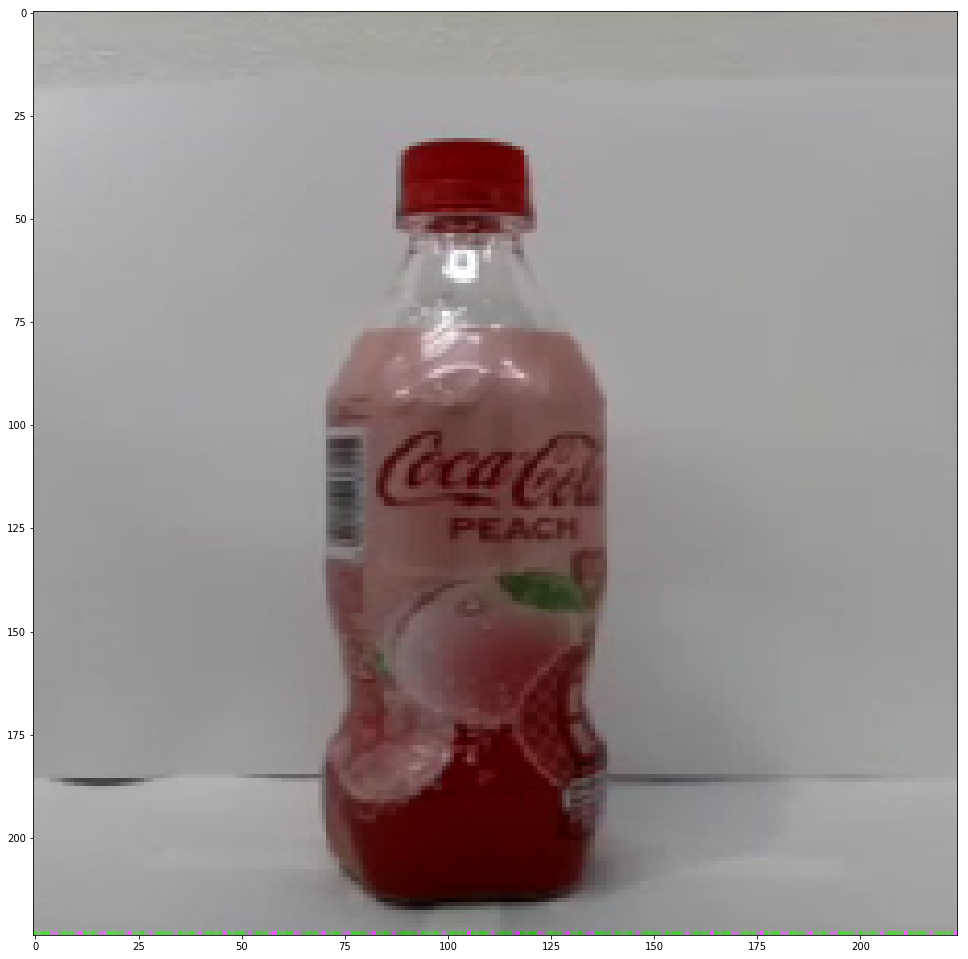

In [50]:
# cola vector
import matplotlib.pyplot as plt
%matplotlib inline
img = './images/test/cocacola-peach/test0.jpg'
plt.figure(figsize=(17,17))
temp_img=load_img(img)
temp_img = temp_img.resize((224, 224))
plt.imshow(temp_img)
temp_img_array=img_to_array(temp_img)
temp_img_array=temp_img_array.astype('float32')/255.0
temp_img_array=temp_img_array.reshape((1,224,224,3))
cola_vector1 = model3.predict(temp_img_array)

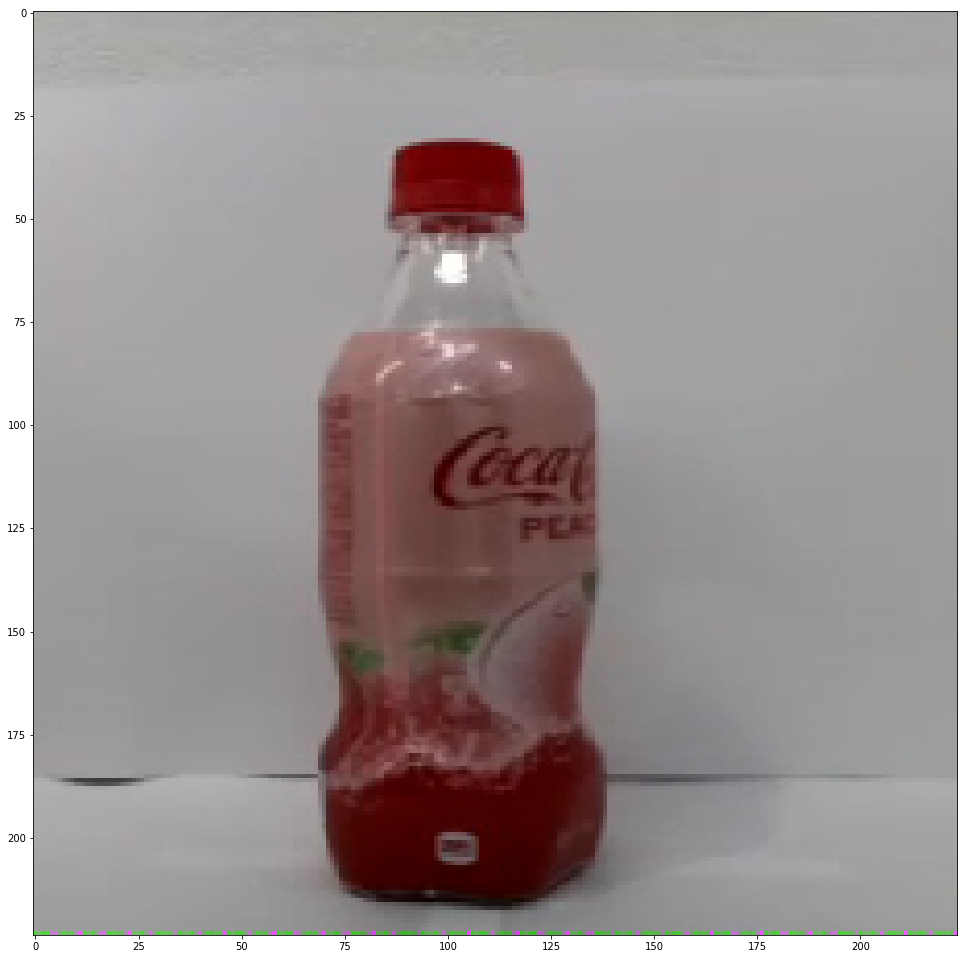

In [51]:
# cola vector
import matplotlib.pyplot as plt
%matplotlib inline
img = './images/test/cocacola-peach/test1.jpg'
plt.figure(figsize=(17,17))
temp_img=load_img(img)
temp_img = temp_img.resize((224, 224))
plt.imshow(temp_img)
temp_img_array=img_to_array(temp_img)
temp_img_array=temp_img_array.astype('float32')/255.0
temp_img_array=temp_img_array.reshape((1,224,224,3))
cola_vector2 = model3.predict(temp_img_array)

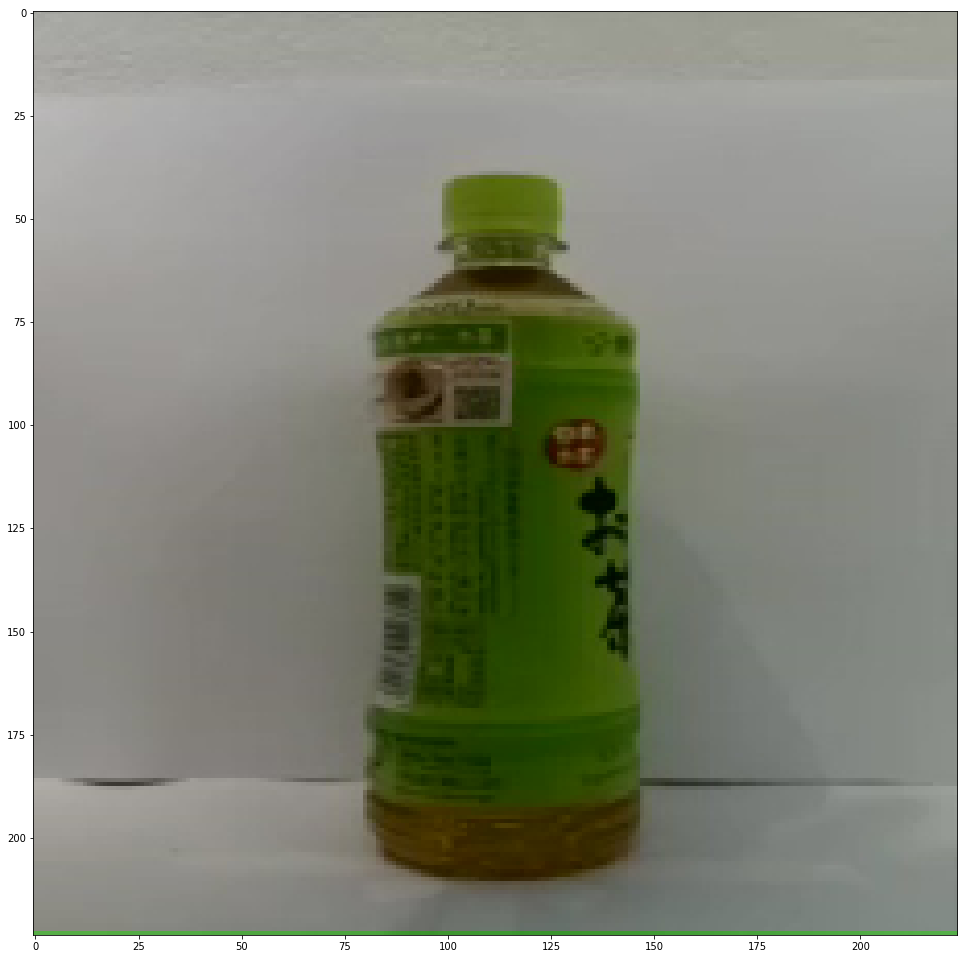

In [44]:
# o-iocha vector
%matplotlib inline
img = './images/test/o-iocha/test1.jpg'
plt.figure(figsize=(17,17))
temp_img=load_img(img)
temp_img = temp_img.resize((224, 224))
plt.imshow(temp_img)
temp_img_array=img_to_array(temp_img)
temp_img_array=temp_img_array.astype('float32')/255.0
temp_img_array=temp_img_array.reshape((1,224,224,3))
ocha_vector = model3.predict(temp_img_array)

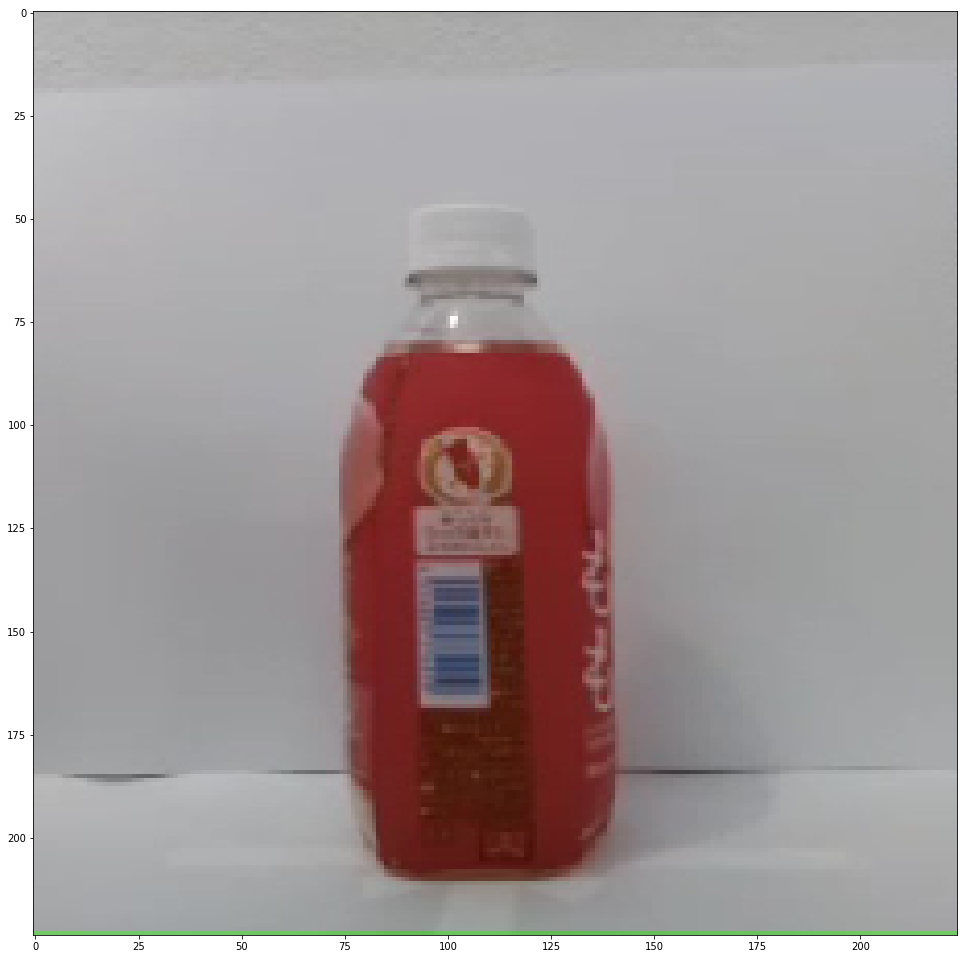

In [45]:
# kuchidoke vector
%matplotlib inline
img = './images/test/kuchidoke-momo/test1.jpg'
plt.figure(figsize=(17,17))
temp_img=load_img(img)
temp_img = temp_img.resize((224, 224))
plt.imshow(temp_img)
temp_img_array=img_to_array(temp_img)
temp_img_array=temp_img_array.astype('float32')/255.0
temp_img_array=temp_img_array.reshape((1,224,224,3))
kuchidoke_vector = model3.predict(temp_img_array)

In [52]:
cosin_metric(kuchidoke_vector,cola_vector1)

array([[0.8749711]], dtype=float32)

In [53]:
cosin_metric(cola_vector1,cola_vector2)

array([[0.94929194]], dtype=float32)

In [54]:
cosin_metric(kuchidoke_vector,ocha_vector)

array([[0.8054367]], dtype=float32)

In [39]:
model.get_layer(index=-3)

In [48]:
model2.layers[-2].get_weights()

[array([[-4.8161782e-03, -5.0263931e-03,  2.1304714e-02, -5.0948723e-03,
         -5.0489167e-03],
        [-1.1489937e-03, -1.1409174e-03, -1.1484358e-03, -1.1473418e-03,
          4.5249891e-03],
        [-2.3090150e-02, -2.3067474e-02, -2.3083109e-02,  9.1405660e-02,
         -2.3088526e-02],
        ...,
        [-7.1628827e-05, -3.5899764e-05, -1.2811313e-04, -1.2863931e-04,
          3.0662390e-04],
        [-1.7475720e-03, -1.7503622e-03, -1.7598950e-03, -1.7581119e-03,
          6.2879180e-03],
        [ 1.4067555e-06, -6.8680089e-07, -5.8933807e-07, -5.9204558e-07,
         -3.3975135e-07]], dtype=float32)]

In [22]:
model.get_config()

{'name': 'model_1',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'Conv1_pad',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'Conv1_pad',
    'trainable': True,
    'padding': ((0, 1), (0, 1)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'Conv1',
   'class_name': 'Conv2D',
   'config': {'name': 'Conv1',
    'trainable': True,
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'conf

In [11]:
model.predict([x,y])

array([[4.10355527e-09, 6.31175609e-03, 6.31398102e-03, 9.81063068e-01,
        6.31113024e-03],
       [2.46459678e-01, 2.46318460e-01, 2.46381477e-01, 1.45410551e-02,
        2.46299297e-01],
       [2.50255764e-01, 2.50005424e-01, 1.77303093e-07, 2.49812171e-01,
        2.49926507e-01],
       [2.49949381e-01, 2.49682382e-01, 1.74629307e-07, 2.50750452e-01,
        2.49617621e-01],
       [2.49071360e-01, 2.48969138e-01, 2.48999164e-01, 4.03487496e-03,
        2.48925507e-01],
       [1.22096750e-08, 1.93718392e-02, 1.95895024e-02, 9.41667855e-01,
        1.93708595e-02],
       [1.89313829e-01, 1.89154997e-01, 1.31252378e-07, 4.32431906e-01,
        1.89099118e-01],
       [7.02929981e-08, 1.17876194e-01, 1.17838092e-01, 6.46536291e-01,
        1.17749296e-01],
       [2.48866051e-01, 2.50101119e-01, 2.48948902e-01, 2.52083749e-01,
        1.63559420e-07],
       [2.41401225e-01, 2.45427206e-01, 2.43056610e-01, 2.70114839e-01,
        1.52079039e-07],
       [6.12942851e-04, 4.3267

In [28]:
# cosine sim
import keras.backend as K
def keras_cosin_metric(x1, x2):
    x1_norm = K.l2_normalize(x1)
    x2_norm = K.l2_normalize(x2)
    
    return K.dot(x1_norm, x2_norm)

In [41]:
# cos sim numpy
import numpy as np
def cosin_metric(x1, x2):
    x1_norm = np.linalg.norm(x1)
    x2_norm = np.linalg.norm(x2)
    return np.dot(x1, x2.T)/(x1_norm*x2_norm+1e-10)